In [2]:
import os
from pathlib import Path
from typing import Optional

import fastmri
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from data_utils import *
from datasets import *
from fastmri.data.transforms import tensor_to_complex_np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torch.utils.data import DataLoader, TensorDataset

from model import *
from torch.optim import SGD, Adam, AdamW
from train_utils import *

In [3]:
files = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'

dataset = KCoordDataset(files, n_volumes=25, n_slices=2, with_mask=False)
print(len(dataset))
# loader_config = config["dataloader"]
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, collate_fn=collate_fn, pin_memory=PIN_MEMORY, worker_init_fn=seed_worker, generator=RS_TORCH)
# dataloader = DataLoader(
#     dataset,
#     batch_size=960_000,
#     num_workers=0,
#     shuffle=True,
#     pin_memory=True,
#     )

74808320


In [5]:
files = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'

dataset_single = KCoordDataset(files, n_volumes=2, n_slices=2, with_mask=False)
print(len(dataset_single))

6924800


In [6]:
len(dataset_single)//240_000

28

In [4]:
len(dataset)/960_000

77.92533333333333

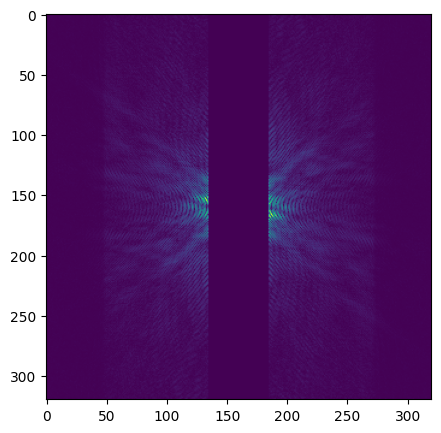

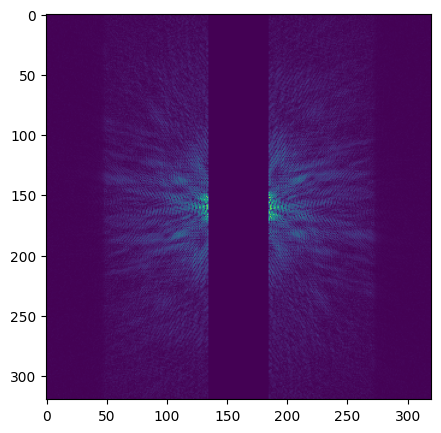

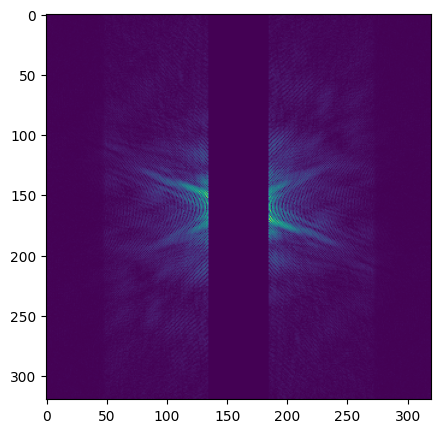

In [7]:
from pathlib import Path

path_to_data = Path('/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/')
n_volumes = 3
left_idx = 135
right_idx = 185

if path_to_data.is_dir():
    files = sorted(
        [
            file
            for file in path_to_data.iterdir()
            if file.suffix == ".h5" and "AXT1POST_205" in file.name
        ]
    )[:n_volumes]
    
n_slices = 2
for file in files:
    with h5py.File(file, "r") as hf:
            kspace = preprocess_kspace(hf["kspace"][()])[:n_slices]
            
            img = rss(inverse_fft2_shift(kspace))
            volume_kspace = fft2_shift(img)
            volume_kspace[..., left_idx:right_idx] = 0
            
            plt.figure(figsize=(5,5))
            plt.imshow(np.abs(volume_kspace[0]))

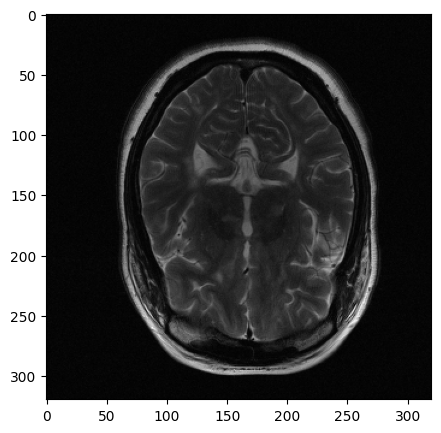

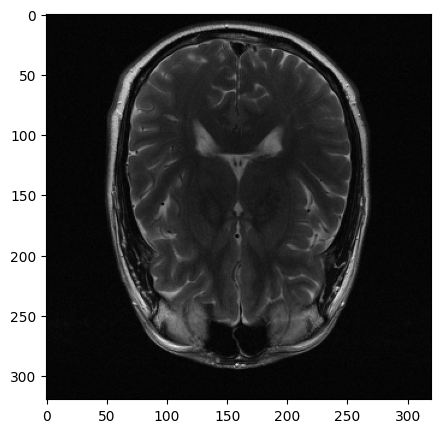

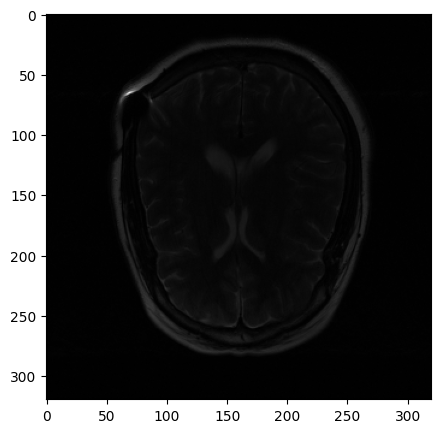

In [11]:
from pathlib import Path

path_to_data = Path('/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_val/')
n_volumes = 3


if path_to_data.is_dir():
    files = sorted(
        [
            file
            for file in path_to_data.iterdir()
            if file.suffix == ".h5" and "AXT2_205" in file.name
        ]
    )[:n_volumes]
    
n_slices = 0
for file in files:
    with h5py.File(file, "r") as hf:
            img = hf["reconstruction_rss"][()]
            
            plt.figure(figsize=(5,5))
            plt.imshow(img[0], cmap='gray')
            

In [28]:
with h5py.File(files[0], "r") as hf:
    print(hf.keys())

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>


In [6]:
model_checkpoint = '/scratch_net/ken/mcrespo/proj_marina/logs/multivol/2024-11-11_09h28m59s/checkpoints/epoch_0999.pt'  # TODO: SET (OR LEAVE COMMENTED).


gamma = 0.1
sigma = 0.01
lr = 5.e-6
embedding_dim = 512

OPTIMIZER_CLASSES = {
    "Adam": Adam,
    "AdamW": AdamW,
    "SGD": SGD,
}

LOSS_CLASSES = {
    "MAE": MAELoss,
    "DMAE": DMAELoss,
    "MSE": MSELoss,
    "MSEDist": MSEDistLoss,
    "HDR": HDRLoss,
    "LogL2": LogL2Loss,
    "MSEL2": MSEL2Loss,
}


model = Siren(hidden_dim=512, embedding_dim=512, L =10, n_layers=8, out_dim=2)
# Load checkpoint.
model_state_dict = torch.load(model_checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict["model_state_dict"])
print("Checkpoint loaded successfully.")

# Only embeddings are optimized.
for param in model.parameters():
    param.requires_grad = False


embeddings = torch.nn.Embedding(
    len(dataset.metadata), embedding_dim
)
torch.nn.init.normal_(
    embeddings.weight.data, 0.0, sigma
)
optimizer = OPTIMIZER_CLASSES["Adam"](
    embeddings.parameters(), lr
)

loss_fn = LOSS_CLASSES["MSEL2"](gamma, sigma)

/tmp/ipykernel_27144/1305819576.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_checkpoint, map_location=torch.device('cpu'))


Checkpoint loaded successfully.


In [5]:

def normalize_fn (data, norm_factor):
    """Function that normalizes a data matrix to the range [-1,1]"""
    n_data = (2*data) / (norm_factor - 1) - 1 
    return n_data

def denormalize_fn (n_data, norm_factor):
    """Function that reverts a normalized data matrix to the original range, specified by norm_factor"""
    data = ((n_data + 1) * (norm_factor - 1))/2
    return data